In [ ]:
# # Load the image
# img_path = 'cimage.jpg'
# image = Image.open(img_path)

# # Get original dimensions of the image
# width, height = image.size

# # Specify the portion of the height to delete from the top (e.g., 200 pixels)
# delete_height_top = 0
# # Specify the portion of the width to delete from the right (e.g., 200 pixels)
# delete_width_right = 0
# # Specify the portion of the height to delete from the bottom (e.g., 200 pixels)
# delete_height_bottom = 0
# # Specify the portion of the width to delete from the left (e.g., 200 pixels)
# delete_width_left = 0

# keep_region = (delete_width_left, delete_height_top, width - delete_width_right, height - delete_height_bottom)

# # Crop the image to keep the region
# cropped_image = image.crop(keep_region)

# # Save the new image
# cropped_image.save('cimage.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Segmented image saved at: stitched_segmented_X.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Segmented image saved at: stitched_segmented_Y.jpg


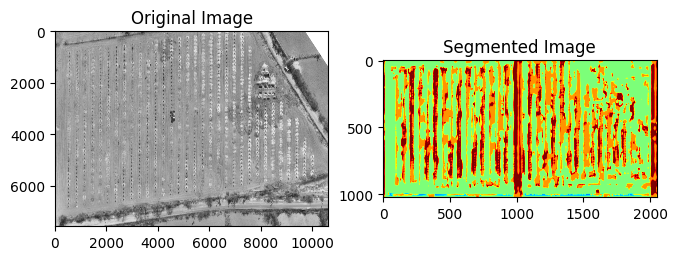

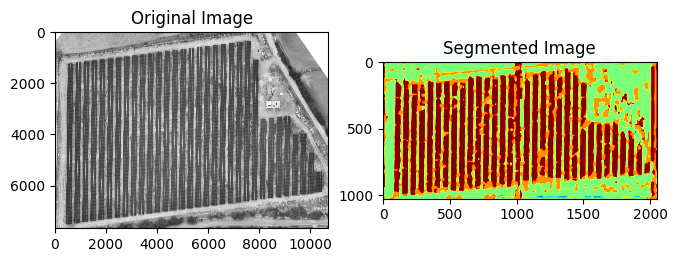

In [ ]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load pre-trained model
model = load_model('test(1).hdf5')

def segment_and_join(image_path, output_path):
    # Load the image
    img = Image.open(image_path)

    # Get image dimensions
    width, height = img.size

    # Compute the middle point for vertical slicing
    middle = width // 2

    # Slice the image into two halves
    left_half = img.crop((0, 0, middle, height))
    right_half = img.crop((middle, 0, width, height))

    # Save sliced halves temporarily
    left_half_path = 'cropped_left.jpg'
    right_half_path = 'cropped_right.jpg'
    left_half.save(left_half_path)
    right_half.save(right_half_path)

    # Segment both halves
    left_segmented = segment_image(left_half_path)
    right_segmented = segment_image(right_half_path)

    # Concatenate the two segmented images
    segmented_image = np.concatenate((left_segmented, right_segmented), axis=1)

    # Save the stitched segmented image
    save_segmented_image(segmented_image, output_path)

    return segmented_image

def segment_image(img_path):
    """Segments a single image using the loaded model."""
    # Read the image in grayscale mode
    img = cv2.imread(img_path, 0)

    # Resize the image to the required size for the model
    img_resized = cv2.resize(img, (1024, 1024))

    # Normalize pixel values
    img_resized = img_resized / 255.0

    # Add required dimensions for model prediction
    img_resized = np.expand_dims(img_resized, axis=-1)  # Shape: (1024, 1024, 1)
    img_resized = np.expand_dims(img_resized, axis=0)   # Shape: (1, 1024, 1024, 1)

    # Generate the prediction from the model
    prediction = model.predict(img_resized)

    # Extract the predicted class by selecting the class with the highest probability (argmax)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]

    return predicted_img

def save_segmented_image(segmented_image, output_path):
    segmented_image_uint8 = np.uint8(segmented_image)
    cv2.imwrite(output_path, segmented_image_uint8)
    print(f"Segmented image saved at: {output_path}")

def plot_images(original_image, segmented_image):
    # Plots the original image and the segmented output side by side.
    plt.figure(figsize=(12, 8))

    # Display the input grayscale image
    plt.subplot(231)
    plt.title('Original Image')
    plt.imshow(original_image, cmap='gray')

    # Display the segmented mask using the 'jet' colormap
    plt.subplot(232)
    plt.title('Segmented Image')
    plt.imshow(segmented_image, cmap='jet')

    plt.show()

# Example usage with _X and _Y
image_X = 'image_X.jpg'
image_Y = 'image_Y.jpg'

# Define output paths for stitched segmented images
output_path_X = 'stitched_segmented_X.jpg'
output_path_Y = 'stitched_segmented_Y.jpg'

# Segment and join for both images, and save the results
segmented_X = segment_and_join(image_X, output_path_X)
segmented_Y = segment_and_join(image_Y, output_path_Y)

# Plot results
plot_images(cv2.imread(image_X, 0), segmented_X)
plot_images(cv2.imread(image_Y, 0), segmented_Y)


In [ ]:
import cv2
import numpy as np

# Updated grayscale class values and corresponding work percentages
class_colors = {
    "unlabelled": 0,
    "boundary": 1,
    "land": 2,
    "poles": 3,
    "solar_panels": 4
}

class_work_percentage = {
    "unlabelled": 0,
    "boundary": 5,
    "land": 10,
    "poles": 30,
    "solar_panels": 100,
    "others": 0  # For pixel values >= 5 which are ambigious pixels (garbage)
}

def get_unique_pixel_values_and_areas(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be read.")

    pixels = image.flatten()  # Flatten the grayscale image

    unique_pixels, counts = np.unique(pixels, return_counts=True)

    # Creates a dictionary that maps each unique pixel to its frequency
    pixel_areas = {pixel: count for pixel, count in zip(unique_pixels, counts)}

    return pixel_areas

def calculate_distance(pixel, color):
    return abs(pixel - color)  # Simple distance for grayscale

def categorize_pixels(pixel_areas, class_colors):
    # Initialize a dictionary to store the total area for each class (initially 0)
    categorized_areas = {class_name: 0 for class_name in class_colors}
    categorized_areas["others"] = 0  # Handle values >= 5

    for pixel, area in pixel_areas.items():
        if pixel >= 5:  # Handle pixel values >= 5
            categorized_areas["others"] += area
        else:
            distances = {class_name: calculate_distance(pixel, color) for class_name, color in class_colors.items()}
            closest_class = min(distances, key=distances.get)
            categorized_areas[closest_class] += area

    return categorized_areas

def calculate_overall_work_done(image_path):
    pixel_areas = get_unique_pixel_values_and_areas(image_path)
    categorized_areas = categorize_pixels(pixel_areas, class_colors)

    total_area = sum(categorized_areas.values())
    weighted_sum = sum(categorized_areas[class_name] * class_work_percentage[class_name] for class_name in class_colors)

    overall_work_done = weighted_sum / total_area

    return overall_work_done

def calculate_difference_in_work_done(image1_path, image2_path):
    overall_work_done_image1 = calculate_overall_work_done(image1_path)
    overall_work_done_image2 = calculate_overall_work_done(image2_path)

    difference = overall_work_done_image2 - overall_work_done_image1

    return overall_work_done_image1, overall_work_done_image2, difference

# Example usage
image1_path = '/content/stitched_segmented_X.jpg'  # First image
image2_path = '/content/stitched_segmented_Y.jpg'  # Second image

work_done_image1, work_done_image2, work_done_difference = calculate_difference_in_work_done(image1_path, image2_path)

print(f"Overall work done on the project site for the first image: {work_done_image1:.2f}%")
print(f"Overall work done on the project site for the second image: {work_done_image2:.2f}%")
print(f"Difference in work done between the two images: {work_done_difference:.2f}%")


Overall work done on the project site for the first image: 30.00%
Overall work done on the project site for the second image: 52.58%
Difference in work done between the two images: 22.58%
